In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json

In [ ]:
!wget https://sherlock-holm.es/stories/plain-text/cnus.txt

DATABASE_FILEPATH = 'cnus.txt'

sequence_length = 100
BATCH_SIZE = 128
BUFFER_SIZE = 12000  # Elements are stored in a buffer of this size

embedding_dim = 128
rnn_units = 896

LEARNING_RATE = 0.001
EPOCHS = 72

--2024-03-24 23:45:54--  https://sherlock-holm.es/stories/plain-text/cnus.txt
Resolving sherlock-holm.es (sherlock-holm.es)... 157.90.249.21, 2a01:4f8:1c17:5725::1
Connecting to sherlock-holm.es (sherlock-holm.es)|157.90.249.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3382026 (3.2M) [text/plain]
Saving to: ‘cnus.txt.1’

cnus.txt.1          100%[===================>]   3.22M  2.82MB/s    in 1.1s    

2024-03-24 23:45:56 (2.82 MB/s) - ‘cnus.txt.1’ saved [3382026/3382026]



In [ ]:
# Load text from the input database
with open(DATABASE_FILEPATH, mode='r') as f:
  all_content = f.read()

print(f'{len(all_content)} characters loaded.')

# Find all the unique characters in the file
unique_chars = sorted(set(all_content))
vocabulary_size = len(unique_chars)

# Create index to vocabulary matching
char_to_idx = {ch:i for i,ch in enumerate(unique_chars)}
idx_to_char = np.array(unique_chars)

# Encode the input text for training
encoded_text = np.array([char_to_idx[char] for char in all_content])
examples_per_epoch = len(all_content) // (sequence_length + 1)

# Package the dataset into batches
character_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
sequences = character_dataset.batch(sequence_length + 1, drop_remainder=True)

# Finalize the dataset
def chunk_data(chunk):
    input = chunk[:-1]
    target = chunk[1:]
    return input, target

dataset = sequences.map(chunk_data)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

3381928 characters loaded.


In [ ]:
def build_model(vocabulary_size, embedding_dim, rnn_units, batch_size):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocabulary_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocabulary_size))

    return model

# Build the model
model = build_model(vocabulary_size, embedding_dim, rnn_units, BATCH_SIZE)

# Compile the model
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

# Handle directory management for checkpoints
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (128, None, 128)          12416     
                                                                 
 lstm (LSTM)                 (128, None, 896)          3673600   
                                                                 
 dense (Dense)               (128, None, 97)           87009     
                                                                 
Total params: 3773025 (14.39 MB)
Trainable params: 3773025 (14.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
training_record = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/72
261/261 [==============================] - 9s 19ms/step - loss: 2.3367
Epoch 2/72
261/261 [==============================] - 6s 15ms/step - loss: 1.6571
Epoch 3/72
261/261 [==============================] - 5s 14ms/step - loss: 1.4290
Epoch 4/72
261/261 [==============================] - 5s 15ms/step - loss: 1.3141
Epoch 5/72
261/261 [==============================] - 5s 14ms/step - loss: 1.2476
Epoch 6/72
261/261 [==============================] - 5s 15ms/step - loss: 1.2025
Epoch 7/72
261/261 [==============================] - 5s 14ms/step - loss: 1.1701
Epoch 8/72
261/261 [==============================] - 5s 15ms/step - loss: 1.1430
Epoch 9/72
261/261 [==============================] - 5s 14ms/step - loss: 1.1201
Epoch 10/72
261/261 [==============================] - 5s 14ms/step - loss: 1.1009
Epoch 11/72
261/261 [==============================] - 5s 14ms/step - loss: 1.0834
Epoch 12/72
261/261 [==============================] - 5s 15ms/step - loss: 1.0670
Epoch 13/72
2

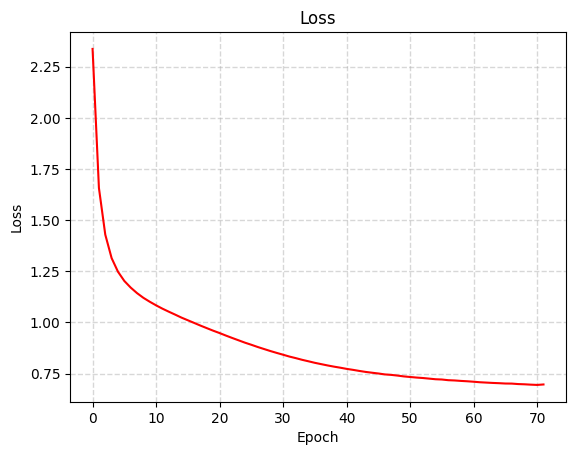

In [ ]:
# Plot the loss graph
def render_training_record(training_record):
    loss = training_record.history['loss']
    plt.plot(loss, color='red')

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_record(training_record)

# Save the loss graph
loss_filename = f'{DATABASE_FILEPATH.split(".")[0]}_lr{LEARNING_RATE}' + \
                f'_units{rnn_units}.json'
with open(loss_filename, 'w') as f:
    json.dump(training_record.history, f)

In [ ]:
# Rebuild the model for inference
inference_batch_size = 1

model = build_model(vocabulary_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([inference_batch_size, None]))

# Function for calling inference with the model
def generate_text(model, initial_chars, generate_length=1000, temperature=1.0):

    # Encode the initial string
    input_indices = [char_to_idx[s] for s in initial_chars]
    input_indices = tf.expand_dims(input_indices, 0)

    text_generated = []
    model.reset_states()

    for char_index in range(generate_length):

        predictions = model(input_indices)
        predictions = tf.squeeze(predictions, 0)  # Remove the extra dimension for batch
        predictions = predictions / temperature

        # Somewhat-randomly sample a following character from the model
        estimated_idx = tf.random.categorical(
          predictions,
          num_samples=1
        )[-1,0].numpy()

        # Now add the predicted character to the running input for the model
        input_indices = tf.expand_dims([estimated_idx], 0)

        text_generated.append(idx_to_char[estimated_idx])

    return (initial_chars + ''.join(text_generated))

In [ ]:
print(generate_text(model, initial_chars=u"     Watson "))

     Watson manage the county. Even them trivial inaction which she said, for I felt that even
     they were any other way; insinted his eyes fixed upon by the water."

     "I never smeled any night to prove it."

     "You!" I said to assure her grim debres and lodging-hour, with no hanged over extent convulsive
     medice?"

     I looked at the arrival of the inner room while you
     get at our bereave so much non5. He seized the
     wooden doctor and slidved up to the black with a
     man as I? What was I dare not touched
     him obtrusive, his hat and picked out the efforts of the upper window. The drunken escape was
     blood. They drove him with the kitchen bounds, and
     the travel hardened to-morrow. T."

     "You never quattered our own reflexal."

     "You are not young man,' I answered. "The word Haturally must
     have been expected to show himself that I should deduce me."

     "How was it where?" I asked.

     My friend was anger. "You mean enough and to q

In [ ]:
print(generate_text(model, initial_chars=u"     Homes "))

     Homes will come to that legal way into both by the promptings of the
     Univermit of the Abbey Grange they would pass when once for
     suicing our attention very rich as it may be of on the smoke. Yet he glowe
     mustion stop that she had appeared in my power to
     the note of the kingdom to be done out in crincing me to force
     you to understand that it turn some more in the room. I lift
     him between Palneys, and his son depressed his head, and her face showed that he was sterror and forwarded and
     impressive effects, Mr. McMurdo; but I think no senseless for very
     clever," said he. "Who is this to lock?"

     "Experience!" said Holmes.

     "I have not strange a month there. But my nerves
     scattered movements money."

     "I came slowly brought pastly," said he. "There is a train to take me away, and we
     forced Baynes's, wall and lit on the side table."

     "I will tell you, now, Watson, we
     have reason alone in a very quiet note upon a co

In [ ]:
print(generate_text(model, initial_chars=u"     Professor Tu "))

     Professor Tu To Halliday's Peorge Street, "I confess that I hate in very first
     track which can poisoner de to his horror, and returned a stick or cellar foresa have been translaged."

     With a thousand tives the smell with his keen eyes upon my writing desk     guard within a few minutes of interest, but written a name?"

     "I cannot think it was always a tool. I have no doubt that I am able to what you have done without. Come along, Dr. Watson. Do there are a
     word to be staged before you by a weapon, it mighty be of no questions.

     On inquiries are fairly often, and only just had thought of the only
     friends to Sherlock Holmes. This, however, is the
     d have
     some little doubt upon a word. A man of darkness of the peculpary
     destruction like you, 'though
     I have a quick glance to leave this very worse than that."

     Holmes sat for some time, for some little time, I found myself at one time that
     ve eserve of his struck for body to kno